In [1]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import GPy

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing
from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
df = pd.read_csv('../../../Data/JIANG/dataVehicle101.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

       TIME    LEAD_POS  FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0     31993   200.67055   188.04780   4.44200     0.00000            5
1     31994   201.11260   188.04780   4.39912     0.00000            5
2     31995   201.55044   188.04780   4.35767     0.00000            5
3     31996   201.98436   188.04780   4.32056     0.00000            5
4     31997   202.41491   188.04780   4.29046     0.00000            5
...     ...         ...         ...       ...         ...          ...
2880  34873  2808.34544  2796.11119   6.35455     5.83341            5
2881  34874  2808.98007  2796.69322   6.33798     5.80710            5
2882  34875  2809.61276  2797.27252   6.31573     5.77881            5
2883  34876  2810.24298  2797.84889   6.28871     5.74871            5
2884  34877  2810.87036  2798.42219   6.25883     5.71735            5

[2885 rows x 6 columns]


In [3]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

t = np.linspace(0, 288.4, 2884, endpoint=False) # 288.4 for JIANG # 188.9 for NAPOLI
#t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)

2885
0


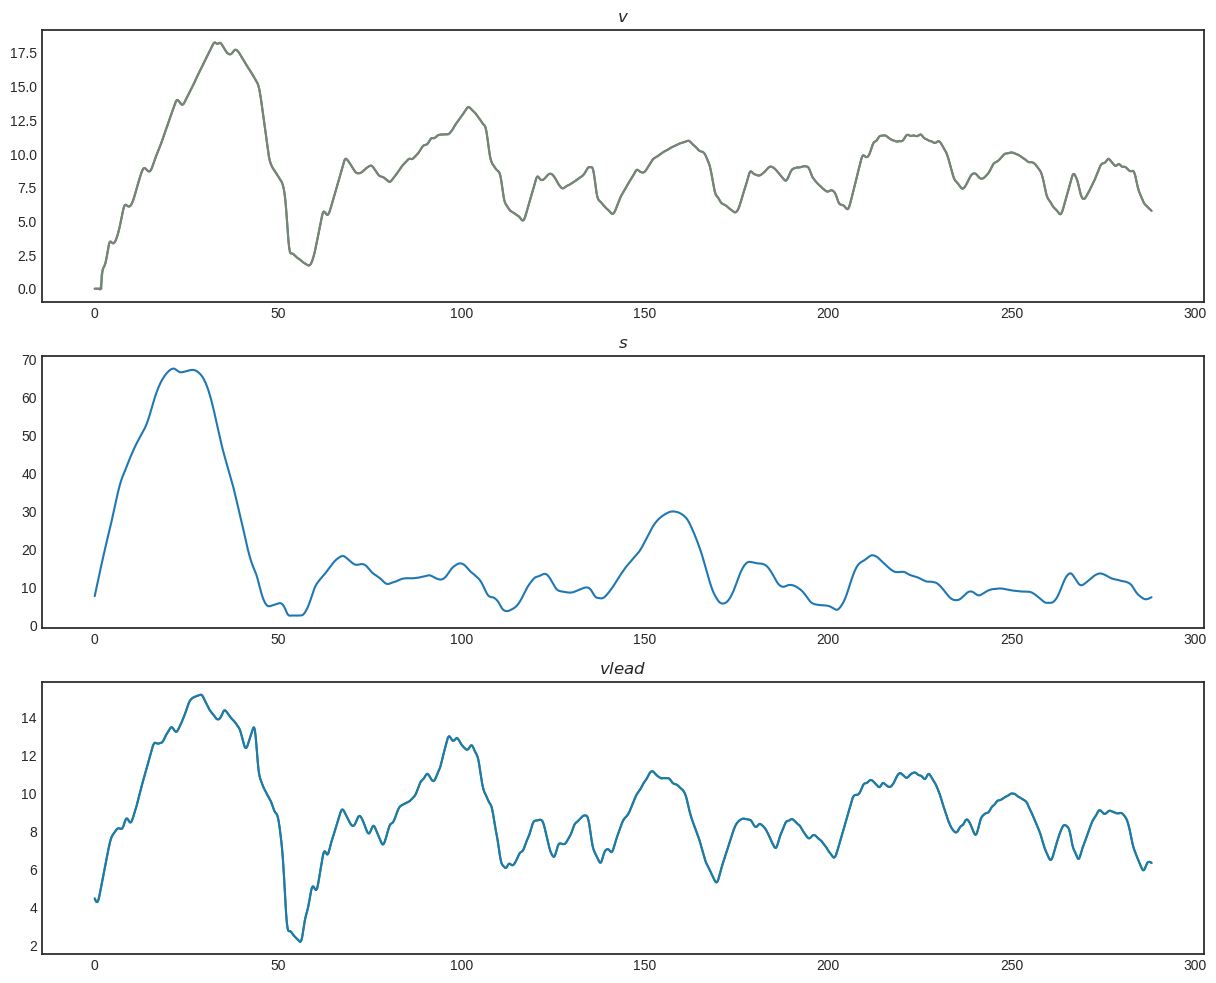

In [4]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

FD_v = FD(followPos[statTraj:endsTraj],t[statTraj:endsTraj])
FD_vlead = FD(leadPos[statTraj:endsTraj],t[statTraj:endsTraj])

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v[statTraj:endsTraj], 'tab:green')
ax1.plot(t[statTraj:endsTraj], FD_v.reshape(followPos[statTraj:endsTraj].shape[0],)[:], 'tab:gray')
ax1.set_title('$v$')
#ax2.plot(t[statTraj:endsTraj], followPos[statTraj:endsTraj], 'tab:green')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj])
#ax2.plot(t[statTraj:endsTraj], leadPos[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.plot(t[statTraj:endsTraj], FD_vlead.reshape(leadPos[statTraj:endsTraj].shape[0],)[:])
ax3.set_title('$vlead$')

plt.show()

# GPy

In [5]:
#st_Traj = 0
#en_Traj = 2308

# Training (UnStandardized)

#X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

#Y_train = v_p[st_Traj:en_Traj].reshape(-1,1)  # RMSE(A)
#Y_train = v[st_Traj+1:en_Traj+1].reshape(-1,1)  # RMSE(V)
#Y_train = s[st_Traj+1:en_Traj+1].reshape(-1,1) # RMSE(S)

# Testing (UnStandardized)

#Y_test = v_p[en_Traj+1:].reshape(-1,1) # RMSE(A)
#Y_test = v[en_Traj+1:].reshape(-1,1)   # RMSE(V)
#Y_test = s[en_Traj+1:].reshape(-1,1)    # RMSE(S)

#X_prior = np.stack((v,s,vlead,t), axis=1) # Prior

In [6]:
st_Traj = 0
en_Traj = 2307 #1551 # 2307 # 9405

# Training (Standardized)
v_mean = v[st_Traj:en_Traj].mean()
v_stdev = v[st_Traj:en_Traj].std()

s_mean = s[st_Traj:en_Traj].mean()
s_stdev = s[st_Traj:en_Traj].std()

vlead_mean = vlead[st_Traj:en_Traj].mean()
vlead_stdev = vlead[st_Traj:en_Traj].std()

v_p_mean = v_p[st_Traj:en_Traj].mean()
v_p_stdev = v_p[st_Traj:en_Traj].std()  

X_train = np.stack(((v[st_Traj:en_Traj]-v_mean)/v_stdev,(s[st_Traj:en_Traj]-s_mean)/s_stdev,(vlead[st_Traj:en_Traj]-vlead_mean)/vlead_stdev,t[st_Traj:en_Traj]), axis=1)

#Y_train = ((v_p[st_Traj+1:en_Traj+1]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
#Y_train = ((v[st_Traj+1:en_Traj+1]-v_mean)/v_stdev).reshape(-1,1)  # RMSE(V)
Y_train = ((s[st_Traj+1:en_Traj+1]-s_mean)/s_stdev).reshape(-1,1) # RMSE(S)

# Testing (Standardized)

#Y_test = ((v_p[en_Traj+1:]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
#Y_test = ((v[en_Traj+1:]-v_mean)/v_stdev).reshape(-1,1)       # RMSE(V)
Y_test = ((s[en_Traj+1:]-s_mean)/s_stdev).reshape(-1,1)       # RMSE(S)

X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [8]:
noise = 0.017

#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)

#myKernel = k1*k2
myKernel = GPy.kern.Exponential(input_dim=3)
gpr = GPy.models.GPRegression(X_train[:,:3], Y_train, kernel=myKernel)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize()

# Display optimized parameter values
display(gpr)

GP_regression.,value,constraints,priors
Exponential.variance,12.259662347531613,+ve,
Exponential.lengthscale,5342.789367794902,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


In [9]:
# Obtain optimized kernel parameters
#l = gpr.mlp.weight_variance.values[0]
#sigma_f = np.sqrt(gpr.mlp.variance.values[0])
#print(l, sigma_f)

# Plot the results with the built-in plot function
mu_s, cov_s = gpr.predict(X_prior[:,:3])
#np.save('ResearchUpdate#43/GPModels/ASTAZERO/GP_Exp_Stand_ASTA(S).npy', gpr.param_array)

In [183]:
#np.savetxt("gp_pred_data.csv", mu_s, delimiter=",")

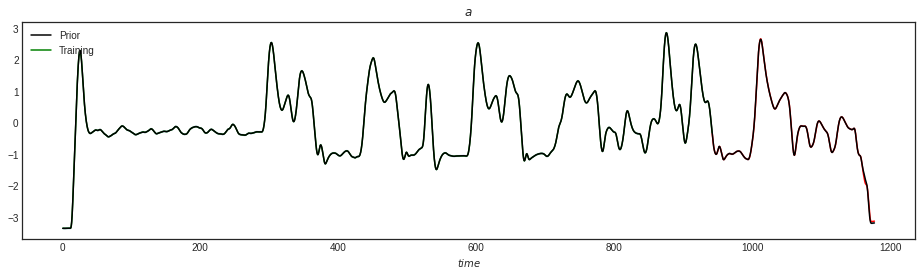

In [10]:
mu = mu_s.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

ax.fill_between(X_prior[:,3], mu + uncertainty, mu - uncertainty, alpha=0.3)
p1, = ax.plot(X_train[:,3], Y_train, 'g')
ax.plot(t[en_Traj+1:], Y_test, 'r')
g1, = ax.plot(X_prior[:,3], mu, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

# RMSE(S)

In [22]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
myKernel = GPy.kern.MLP(input_dim=3)
#myKernel = k1+k2
load_gpr = GPy.models.GPRegression(X_train[:,:3], Y_train, kernel=myKernel, initialize=False)
load_gpr.update_model(False) # do not call the underlying expensive algebra on load
load_gpr.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr[:] = np.load('../GPModels/JIANG/GP_MLP_Stand_JIANG(S).npy') # Load the parameters
load_gpr.update_model(True) # Call the algebra only once
print(load_gpr)


Name : GP regression
Objective : -7257.168096215513
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mlp.variance             |      1200226.1430166007  |      +ve      |        
  mlp.weight_variance      |   4.338829963176561e-07  |      +ve      |        
  mlp.bias_variance        |  5.562684646268137e-309  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [23]:
#X_prior = np.stack((v,s,vlead,t), axis=1)
X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [24]:
mu_gpy = np.zeros(X_prior.shape[0])
cov_gpy = np.zeros((X_prior.shape[0],X_prior.shape[0]))

gpy_a = np.zeros(X_prior.shape[0])
gpy_v = np.zeros(X_prior.shape[0])
gpy_pos = np.zeros(X_prior.shape[0])
gpy_s = np.zeros(X_prior.shape[0])
gpy_vstd = np.zeros(X_prior.shape[0])

gpy_vstd[0] = X_prior[0,0]
gpy_s[0] = s[0]
gpy_pos[0] = followPos[0]
gpy_v[0] = v[0]

for k in range(X_prior.shape[0]):
    mu_gpy[k], cov_gpy[k,:] = load_gpr.predict(X_prior[k,:3].reshape(1,-1))
    if k != X_prior.shape[0]-1:
        X_prior[k+1,1] = mu_gpy[k]
        gpy_s[k+1] = mu_gpy[k]*s_stdev + s_mean  # Unstandardize
        gpy_pos[k+1] = leadPos[k+1] - gpy_s[k+1] - leadLen[0]
        gpy_v[k+1] = (gpy_pos[k+1]-gpy_pos[k]) / 0.1
        #gpy_vstd[k+1] = (gpy_v[k+1]-v_mean) / v_stdev
        X_prior[k+1,0] = (gpy_v[k+1]-v_mean) / v_stdev
        gpy_a[k+1] = (gpy_v[k+1]-gpy_v[k]) / 0.1

In [27]:
# saving data in csv files 
uncertainty = 1.96 * np.sqrt(np.diag(cov_gpy))
allData = np.stack((gpy_s, uncertainty, gpy_v, gpy_a, v_p, v, s), axis=1)
#np.savetxt('../../../Results/GP/Predictions/JIANG/GP_MLP_Stand_JIANG(S).csv', allData, delimiter=',')

In [10]:
# loading predictions from csv files
my_data = genfromtxt('../../../Results/GP/Predictions/JIANG/GP_MLP_Stand_JIANG(S).csv', delimiter=',')
gpy_s = my_data[:,0]
uncertainty = my_data[:,1]
gpy_v = my_data[:,2]
gpy_a = my_data[:,3]
v_p = my_data[:,4]
v = my_data[:,5]
s = my_data[:,6]

GP Acc. RMSE: 0.5780341562758748
GP Vel. RMSE 3.563624555005235
GP Head. RMSE 56.45945859706428
GP Acc. RMSE: 0.48677739797960345
GP Vel. RMSE 1.625705313023891
GP Head. RMSE 41.312844112769945


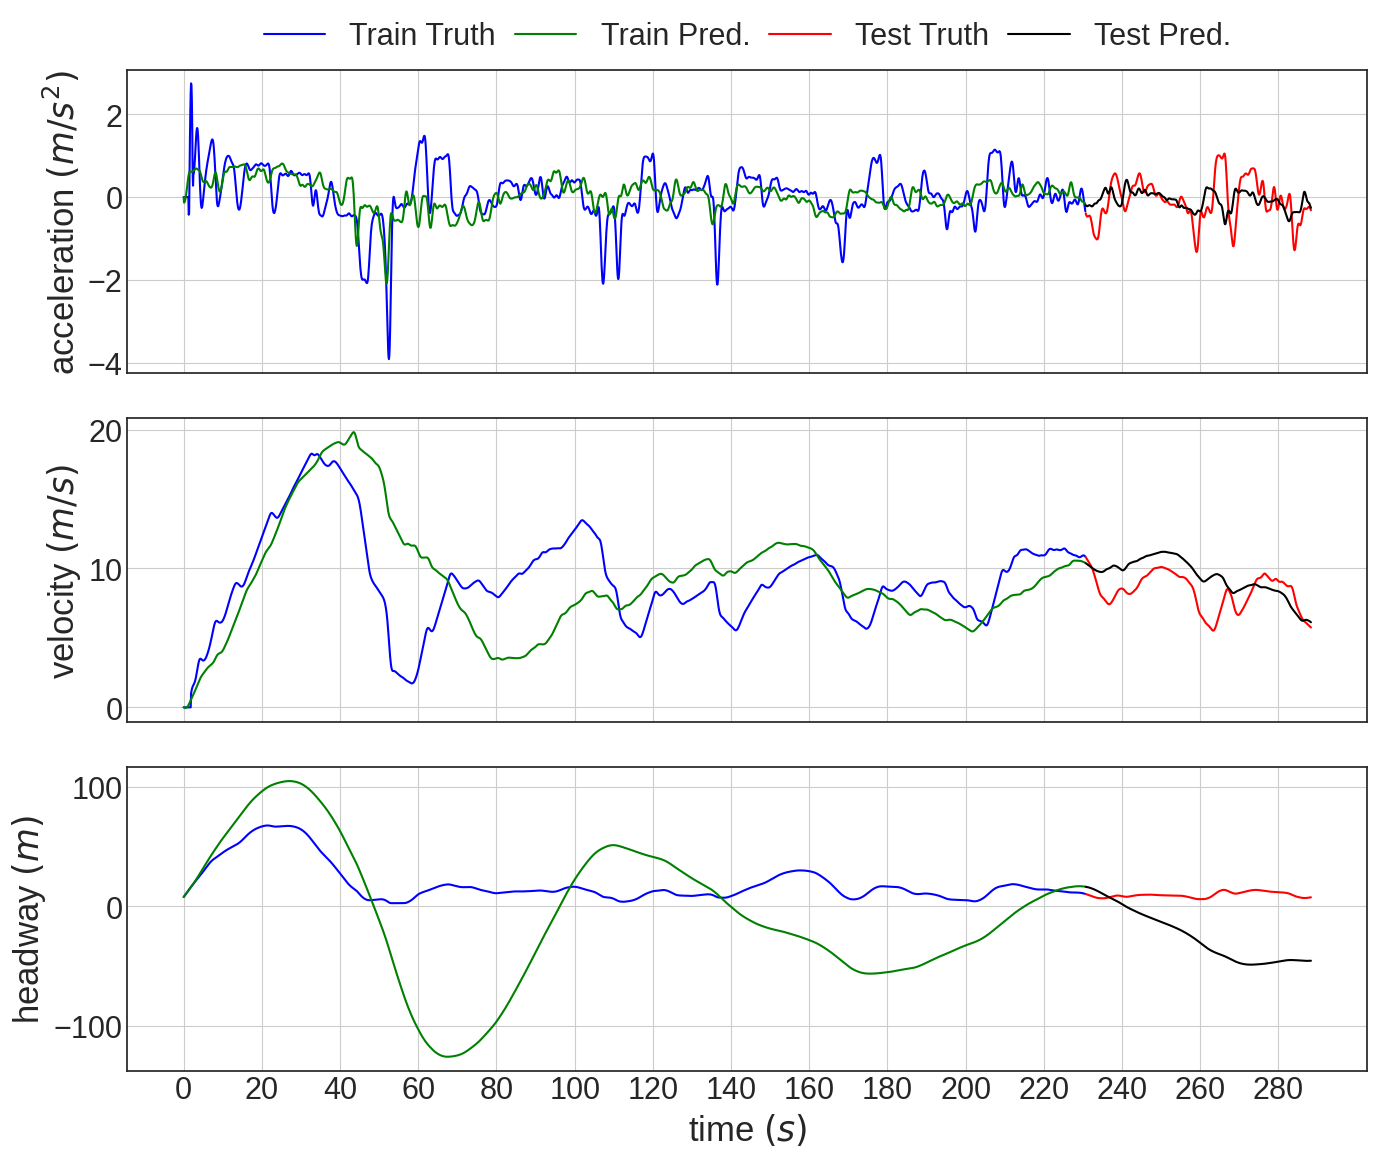

In [13]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

print('GP Acc. RMSE:', np.sqrt(mean_squared_error(gpy_a[:en_Traj], v_p[:en_Traj])))
print("GP Vel. RMSE", np.sqrt(mean_squared_error(gpy_v[:en_Traj], v[:en_Traj])))
print("GP Head. RMSE", np.sqrt(mean_squared_error(gpy_s[:en_Traj], s[:en_Traj])))

print('GP Acc. RMSE:', np.sqrt(mean_squared_error(gpy_a[en_Traj:], v_p[en_Traj:])))
print("GP Vel. RMSE", np.sqrt(mean_squared_error(gpy_v[en_Traj:], v[en_Traj:])))
print("GP Head. RMSE", np.sqrt(mean_squared_error(gpy_s[en_Traj:], s[en_Traj:])))

fig = plt.figure() 

gs = fig.add_gridspec(3, hspace=0.15)
ax = gs.subplots(sharex=True)

fig.set_figheight(13)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

mu = gpy_s.ravel()
#uncertainty = 1.96 * np.sqrt(np.diag(cov_gpy))

b1, = ax[0].plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax[0].plot(X_prior[:en_Traj,3], gpy_a[:en_Traj], "g")
r1, = ax[0].plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax[0].plot(X_prior[en_Traj:,3], gpy_a[en_Traj:], "k")
ax[0].set_ylabel('acceleration $(m/s^2)$')
ax[0].grid(True)
ax[0].xaxis.set_ticks(np.arange(min(t), max(t), 20))

ax[1].plot(X_train[:,3], v[:en_Traj], "b")
ax[1].plot(X_prior[:en_Traj,3], gpy_v[:en_Traj], "g")
ax[1].plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax[1].plot(X_prior[en_Traj:,3], gpy_v[en_Traj:], "k")
ax[1].set_ylabel('velocity $(m/s)$')
ax[1].grid(True)

ax[2].fill_between(X_prior[:,3], mu + uncertainty, mu - uncertainty, alpha=0.3)
ax[2].plot(X_train[:,3], s[:en_Traj], "b")
ax[2].plot(X_prior[:en_Traj,3], gpy_s[:en_Traj], "g")
ax[2].plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax[2].plot(X_prior[en_Traj:,3], gpy_s[en_Traj:], "k")
ax[2].set_ylabel('headway $(m)$')
ax[2].grid(True)
ax[2].set_xlabel('time $(s)$')

ax[0].legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test Truth', 'Test Pred.'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)

plt.savefig('../../../Results/GP/Plots/JIANG/GP_MLP_Stand_JIANG(S).png')
plt.show()